In [2]:
from transformers import YolosFeatureExtractor, YolosForObjectDetection, BatchFeature
import torch.nn as nn
import torch
from pytorch_lightning import Trainer
import wandb
from pathlib import Path
import numpy as np
import math
from tqdm import tqdm
from abbyy_course_cvdl_t3.coco_text import COCO_Text

In [ ]:
feature_extractor = YolosFeatureExtractor.from_pretrained('hustvl/yolos-tiny')
model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny', num_labels=1,
                                                             ignore_mismatched_sizes=True)

In [4]:
anno_path = 'cocotext.v2.json'
image_path = '/content/train2014/'

In [6]:
ct = COCO_Text(anno_path)

loading annotations into memory...
0:00:02.207675
creating index...
index created!


In [7]:
from abbyy_course_cvdl_t3.coco_text import COCO_Text
from abbyy_course_cvdl_t3 import coco_evaluation
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection, CocoDetectionPrepareTransform

In [10]:
class MyDataset(CocoTextDetection):
    def _load_target(self, id):
        annos = []
        target_anno_ids = self._image_anno_index[self.ids[id]]
        for ann_id in target_anno_ids:
            ann = self.ann_data['anns'][str(ann_id)]
            ann['category_id'] = int(ann['class'] != 'machine printed')
            annos.append(ann)

        return annos


    def __getitem__(self, index):
        image = self._load_image(index)
        target = self._load_target(index)
        if self.transforms:
            image, target = self.transforms(image, target)
        image_id = self.ids[index]
        target = {'image_id': image_id, 'annotations': target}
        encoding = feature_extractor(image, target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]
        return pixel_values, target

In [42]:
ds_train = MyDataset(
    Path(image_path),
    Path(anno_path),
    transforms=CustomTransform()
)

In [12]:
ds_val = MyDataset(
    Path(image_path),
    Path(anno_path),
    split='val'
)

In [14]:
def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['labels'] = labels
    return batch

In [15]:
trainloader = torch.utils.data.DataLoader(
    ds_train, batch_size=2, shuffle=True, collate_fn=collate_fn
)

In [16]:
valloader = torch.utils.data.DataLoader(
    ds_val, batch_size=1, shuffle=False, collate_fn=collate_fn
)

In [ ]:
wandb.login()

In [20]:
import pytorch_lightning as pl
from transformers import DetrConfig, AutoModelForObjectDetection

class YoloS(pl.LightningModule):

    def __init__(self, lr, weight_decay):
        super().__init__()
        self.model = model
        self.lr = lr
        self.weight_decay = weight_decay
        self.save_hyperparameters()

    def forward(self, pixel_values):
        outputs = self.model(pixel_values=pixel_values)

        return outputs
     
    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("train/loss", loss) 
        for k,v in loss_dict.items():
            self.log("train/" + k, float(v.item()))

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss)
        for k,v in loss_dict.items():
            self.log("validation/" + k, float(v.item()))

        return loss

     def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                  weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
        
        return [optimizer]#, [scheduler]

     def train_dataloader(self):
        return trainloader

     def val_dataloader(self):
        return valloader

In [21]:
model_wrapper = YoloS(lr=2.5e-6, weight_decay=1e-4)

In [ ]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

wandb_logger = WandbLogger(project='cvdl_task_3', log_model=True)

checkpoint_callback = ModelCheckpoint(monitor="validation/loss", mode="min", dirpath='/content/drive/MyDrive/', save_top_k=-1)

In [ ]:
from pytorch_lightning import Trainer

trainer = Trainer(gpus=1, max_epochs=100, gradient_clip_val=0.1, accumulate_grad_batches=1, 
                  log_every_n_steps=100, logger=wandb_logger, callbacks=[checkpoint_callback])
trainer.fit(model_wrapper)

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)

Загрузка модели из чекпоинта трейнера:

In [ ]:
checkpoint = torch.load('checkpoint.ckpt', map_location='cpu')

In [ ]:
state_dict = {}
for key, item in checkpoint['state_dict'].items():
    state_dict[key[6:]] = item

In [ ]:
model.load_state_dict(state_dict)

<All keys matched successfully>

Загрузка из state dict модели (приложен в файлах):

In [ ]:
model.load_state_dict(torch.load('model_checkpoint.pth'))

In [ ]:
model.eval();
model.cpu();

In [ ]:
images_path = Path(image_path)

Text(0.5, 1.0, 'GT: 101243')

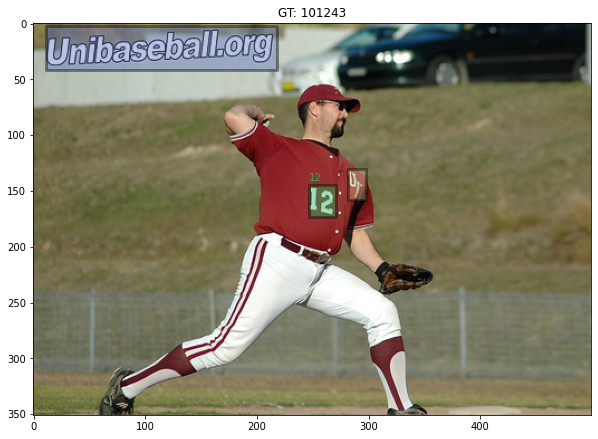

In [ ]:
img_id = 101243
img_meta = ct.loadImgs(ids=[img_id])[0]
plt.imshow(plt.imread(images_path / img_meta['file_name']))
annIds = ct.getAnnIds(imgIds=img_meta['id'])
anns = ct.loadAnns(annIds)
ct.showAnns(anns)
plt.title(f"GT: {img_meta['id']}")


In [ ]:
ds_val = CocoTextDetection(
    Path(image_path),
    Path(anno_path),
    transforms=CocoDetectionPrepareTransform(size=(640, 640)),
    split='val'
)

In [ ]:
img, anno = ds_val[ds_val.ids.index(str(img_id))]

In [ ]:
preds = feature_extractor.post_process(model(**feature_extractor(img, return_tensors="pt")), torch.tensor([640, 640]).unsqueeze(0))[0]

In [ ]:
import torchvision

Text(0.5, 1.0, 'Pred: все боксы')

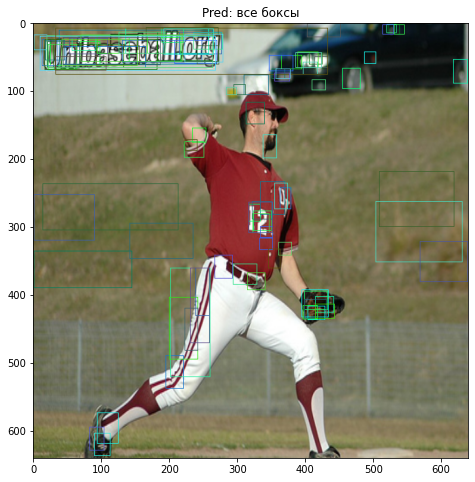

In [ ]:
plt.imshow(
    torchvision.utils.draw_bounding_boxes(
        (img * 255 ).type(torch.uint8), 
        preds['boxes'],
    ).permute(1, 2, 0),
)
plt.title("Pred: все боксы")

Text(0.5, 1.0, 'Pred: боксы с score > 0.35')

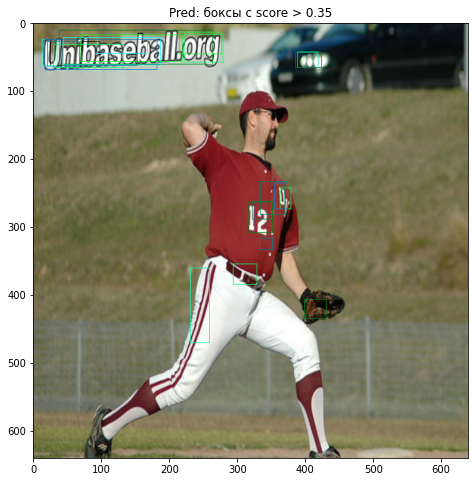

In [ ]:
high_confidence_scores = preds['scores'] > 0.35
high_confidence_boxes = preds['boxes'][high_confidence_scores]
plt.imshow(
    torchvision.utils.draw_bounding_boxes(
        (img * 255 ).type(torch.uint8), 
        high_confidence_boxes
    ).permute(1, 2, 0),
)
plt.title("Pred: боксы с score > 0.35")

In [ ]:
def postprocess(preds, size_src=None, size_current=None):
    """
    Перевод предсказаний Retina в формате [xmin, ymin, xmax, ymax], 
    в формат COCO [xmin, ymin, wx, hy]
    Масштабирование боксов согласно оригинальному размеру изображения.
    """
    unfold_results = {}
    unf = {"scores": preds["scores"].cpu().detach().numpy()}
    b = preds["boxes"].clone().detach()
    boxes = b.clone()
        
    boxes[:, 2] = (b[:, 2] - b[:, 0])
    boxes[:, 3] = (b[:, 3] - b[:, 1])
    if size_src is not None and size_current is not None:
        mult_0 = size_src[0] / size_current[0]
        mult_1 = size_src[1] / size_current[1]

        boxes[:, 0] *= mult_0
        boxes[:, 2] *= mult_0
        boxes[:, 1] *= mult_1
        boxes[:, 3] *= mult_1
    unf['boxes'] = boxes.numpy()
        
    return unf

In [ ]:
prepared_preds = []
img_ids = []

for num, img_id in enumerate(tqdm(ds_val.ids)):
    img_id = int(img_id)
    img_meta = ct.loadImgs(ids=[img_id])[0]
    with torch.no_grad():
        x = ds_val[num][0]
        pred = feature_extractor.post_process(model(**feature_extractor(x, return_tensors="pt")), torch.tensor([640, 640]).unsqueeze(0))[0]
        prepared_preds.append(
            postprocess(
                pred,
                size_src=[img_meta['width'], img_meta['height']], 
                size_current=[640, 640]
            )
        )
        img_ids.append(img_id)


100%|██████████| 4446/4446 [1:04:21<00:00,  1.15it/s]


In [ ]:
from abbyy_course_cvdl_t3.utils import dump_detections_to_cocotext_json

In [ ]:
scores = np.concatenate([u['scores'] for u in prepared_preds])
boxes = np.concatenate([u['boxes'] for u in prepared_preds], axis=0)

In [ ]:
image_ids = []
for num, i in enumerate(img_ids):
    image_ids += [i] * len(prepared_preds[num]['boxes'])
image_ids = np.array(image_ids)

In [ ]:
dump_detections_to_cocotext_json(
    image_ids = image_ids.tolist(),
    xlefts=boxes[:, 0].tolist(),
    ytops=boxes[:, 1].tolist(),
    widths=boxes[:, 2].tolist(),
    heights=boxes[:, 3].tolist(),
    scores=scores.tolist(),
    path='predictions.json'
);
    

In [ ]:
from abbyy_course_cvdl_t3.utils import evaluate_ap_from_cocotext_json

In [ ]:
ap, prec, rec = evaluate_ap_from_cocotext_json(
    coco_text=ct,
    path='predictions.json'
)
print(f"Итоговый скор AP на val: {ap}")